In [ ]:
#imports

!pip install keras-tuner
!pip install scikeras
import json
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow import keras
import keras_tuner
import tensorflow as tf
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier
from keras.utils import to_categorical

In [3]:
#read_csv

data = pd.read_csv('/content/drive/MyDrive/DataFrame.csv', index_col = 'Unnamed: 0' )

In [26]:
#data_for_model

N = 200 #number_of_rows
seq_len = 14 #size_of_window
number_of_unique_chords = 193
row_len = 100
batch_len = 7


X_dur = np.zeros((N*(row_len-seq_len), batch_len))
X_chord = np.zeros((N*(row_len-seq_len), batch_len))
Y = np.zeros((N*(row_len-seq_len), number_of_unique_chords))


for i in range(N*(row_len-seq_len)):
  row = data.iloc[i//(row_len-seq_len)]

  for k in range(0, row_len-seq_len, 2):
    x = row[k:k+seq_len-2] #slice
    y = row[k+seq_len-2:k+seq_len]

    for j in range(0, len(x)-1, 2):
        chord = x[j]
        duration = x[j+1]
        X_chord[i][j//2] = chord
        X_dur[i][j//2] = duration

    validation_chord = y[0]
    arr = np.zeros((1, number_of_unique_chords))
    arr[0][int(validation_chord)] = 1
    Y[i] = arr


X_chord = to_categorical(X_chord)
X_dur = (X_dur - X_dur.mean()) / X_dur.std()
X = np.empty((N*(row_len-seq_len), batch_len, number_of_unique_chords+1))


for i in range(N*(row_len-seq_len)):
  for j in range(batch_len):
      a = X_chord[i][j]
      b = np.zeros((1,))
      b[0] = X_dur[i][j]
      c = np.concatenate((a, b), axis=0)
      X[i][j] = c


X_train, X_validation, y_train, y_validation = train_test_split(X, Y, random_state=42, test_size=0.2, shuffle=True)

In [ ]:
#model

model = Sequential()
model.add(LSTM(512, activation = 'tanh', input_shape = (batch_len, number_of_unique_chords + 1)))
model.add(Dropout(0.2))

model.add(Dense(256, activation = 'tanh'))
model.add(Dropout(0.2))

model.add(Dense(512, activation = 'tanh'))
model.add(Dropout(0.2))

model.add(Dense(193, activation = 'softmax'))

initial_learning_rate = 0.001
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.9)

opt = tf.keras.optimizers.Adam(
    learning_rate = lr_schedule
)

model.compile(optimizer = opt ,loss = 'categorical_crossentropy', metrics = ['accuracy'])
history = model.fit(X_train, y_train, validation_split = 0.2, epochs = 20, batch_size = 16)

In [9]:
#save_model

model.save('/content/drive/MyDrive/best_model_for_chords1')

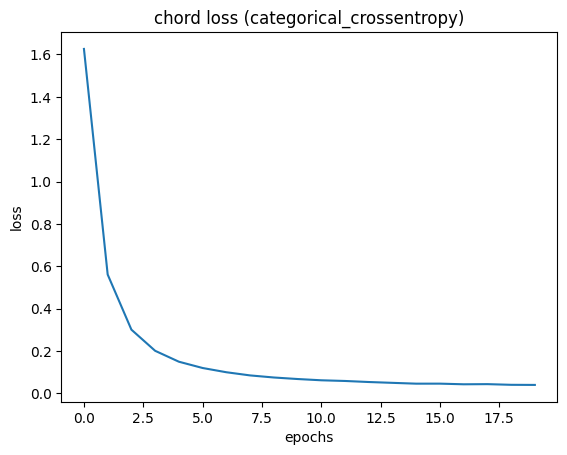

In [20]:
#plot

plt.plot(history.history['loss'])
plt.title('chord loss (categorical_crossentropy)')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.show()

In [23]:
#test_for_one_chord

t = np.reshape(X_validation[0], (1, 7, 194)) #you_can_choose_index_for_X_validation
predicted_chord = model.predict(t)
predicted_chord = np.argmax(predicted_chord)
print(predicted_chord)

In [24]:
#decode, encode, convert and filler

def decode_chord_data(chord_data):
    file = open("/content/drive/MyDrive/Decode.json")
    decoder = json.load(file)
    file.close()

    res = []
    for chord, duration in chord_data:
        res.append((decoder[str(chord)], duration))

    return res


def encode_chord_data(chord_data):
    file = open("/content/drive/MyDrive/Decode.json")
    decoder = json.load(file)
    file.close()

    encoder = dict()
    for key, value in decoder.items():
        encoder[value] = int(key)

    res = []
    for chord, duration in chord_data:
        res.append((encoder[chord], duration))

    return res


def convert(arr):
  new_arr = np.zeros((1, 7, 194))
  for i in range(len(arr)-1, 2):
    chord = arr[i]
    dur = arr[i+1]
    new_arr[0][i][chord] = 1
    new_arr[0][i][193] = arr[i]

  return new_arr

def filler(arr):
    for_model = []
    while(len(for_model) < 98):
        for_model += arr
    return for_model[-98:]

In [25]:
#predict

def predict_sequence(chord_data, n):
  chord_data = encode_chord_data(chord_data)
  sequence = [i for p in chord_data for i in p]
  result = list(chord_data)

  seq = []
  if len(sequence) > 98:
        sequence = sequence[-98:]
  elif len(sequence) < 98:
      sequence = filler(sequence)
  for i in range(0, len(sequence)-1, 2):
        chord = sequence[i]
        duration = sequence[i+1]
        seq.append(chord)
        seq.append(duration)

  for i in range(n):
    random.shuffle(seq)
    seq_for_predict = convert(seq)
    predicted_chord = model.predict(seq_for_predict)
    predicted_chord = int(np.argmax(predicted_chord))
    predicted_duration = (i+78) / 10
    seq.append(predicted_chord)
    seq.append(predicted_duration)
    seq = seq[2:]
    result.append((predicted_chord, predicted_duration))
  return decode_chord_data(result)

a = predict_sequence((("F", 2), ("C", 5), ("D", 1), ("Cdim", 4), ("D", 2), ("A", 5), ("F#", 1), ("Cdim", 4)), n = 4) #n - number of chords
print(a)